In [1]:
include("src/model.jl")

Main.CESModel

## Loading in Data

In [2]:
data = CESModel.read_data("I-O_DE2019_formatiert.csv")

Main.CESModel.CESData(84×87 DataFrame
 Row │ Sektoren                           Erz. d. Landwirtschaft, Jagd und Die ⋯
     │ String                             Int64                                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Erz. d. Landwirtschaft, Jagd und…                                       ⋯
   2 │ Forstwirtschaftl. Erzeugnisse un…
   3 │ Fische, Fischerei- und Aquakultu…
   4 │ Kohle
   5 │ Erdöl und Erdgas                                                        ⋯
   6 │ Erze, Steine und Erden, sonstige…
   7 │ Nahrungs- u. Futtermittel, Geträ…
   8 │ Textilien, Bekleidung, Leder und…
  ⋮  │                 ⋮                                          ⋮            ⋱
  78 │ Bruttolöhne und -gehälter                                               ⋯
  79 │ Sonst.Produktionsabgaben abzgl. …
  80 │ Abschreibungen
  81 │ Nettobetriebsüberschuss
  82 │ Bruttowertschöpfung                                                     ⋯
  

## Setting Elasticities

Es können verschiedene Elastizitäten gesetzt werden, die hier verwendeten sind übernommen aus B&F 2019 
(el. of substitiution of inermediates = 0.0001, el labor/intermediates  = 0.5 el. of consumption = 0.9)

In [3]:
elasticities = CESModel.Elasticities(0.0001, 0.5, 0.9)

Main.CESModel.Elasticities(0.0001, 0.5, 0.9)

## Setting Shocks

Shocks können entweder mit `calculate_investment!` in  1000€ eingegeben werden, oder die einzelnen Elemente im Vektor können auch direkt verändernt werden (z.b `supply_shock[12] = 1.2`), was dann einem Anstieg an demand von 20% entsrpicht.

In [4]:
deman_shock = ones(71)
supply_shock = ones(71)
shocks = CESModel.Shocks(supply_shock,deman_shock) 
#shocks.demand_shock[35] = 1.09
CESModel.calculate_investment!(shocks,data,25000,"Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten")

1.2048978788971576

## Full labor reallocation

In [5]:
price,quantity = CESModel.solve_ces_model(data,shocks,elasticities)

([0.9414662771283958, 0.685577060090985, 0.6244054586459443, 0.7988094318208012, 0.7256080001106276, 0.7980692412591335, 0.94134727511422, 0.8399371285656811, 0.7209376231454425, 0.9065230798549575  …  0.9374540563116699, 0.9365461354636687, 0.9396953689492495, 0.9447017210433857, 0.9573774851060046, 0.9384808316651654, 0.9357786376989119, 0.9267620543014209, 0.865127100350274, 0.9377494149784242], [0.01782284256916136, 0.002698048243079146, 0.0001923686116389358, 0.0010484615291857283, 0.0005707884229604307, 0.005050754335328762, 0.06459037348601994, 0.00763482332417193, 0.009157820799896374, 0.014907716432191012  …  0.08476074351186007, 0.011993745199906815, 0.0592205471991995, 0.0776244571231418, 0.03495355401150267, 0.011428410192898692, 0.009859295553372093, 0.014517220159642885, 0.0015135389093517662, 0.01793051333348333])

In [6]:
println("Real GDP: $(CESModel.real_gdp(price,quantity,data))")
println("Nominal GDP: $(CESModel.nominal_gdp(price,quantity,data))")


Real GDP: 1.0996241642069269
Nominal GDP: 0.9562693811307932


## No labor reallocation 

Es können verschiedene Funktionen angegeben werden,die zurückgeben wie viel Arbeit in den einzelnen Sektoren verfügbar. Hier in diesem Fall, ist keine zusätzliche Arbeit verfügbar, die funktion könnte aber auch zum Beispiel so aussehen: 
```julia
labor_realloc(data) = min(1.05 * data.labor_share,inv(I - diagm(1 .- data.factor_share) * data.Ω) * (data.consumption_share_gross_output .* ((data.shocks.demand_shock .* data.labor_share) - data.labor_share)) + data.labor_share)
``` 
(maximal 5% der verfügbaren Arbeit kann zusätzlich verwendet werden um der gesteigerten Nachfrage nachzukommen)

In [7]:
labor_realloc(data) = data.labor_share #no labor_reallocation

labor_realloc (generic function with 1 method)

In [8]:
price,quantity = CESModel.solve_ces_model(data,shocks,elasticities,labor_reallocation = labor_realloc)

([0.9211476326834687, 0.9270650861003219, 0.9214515885956156, 0.924778748659176, 0.9207069808903681, 0.9279351407719361, 0.9217875982036807, 0.9206552309309273, 0.9440167203450386, 0.9217529350560211  …  0.9254894852218186, 0.9240724053214946, 0.9219802359949434, 0.9208790433587776, 0.9225067669391657, 0.9227726066407185, 0.9213228347327406, 0.9240239327822531, 0.9207874619164009, 0.9205055190333151], [0.017682137674283366, 0.0022078507670756243, 0.00016202835691791548, 0.0009671103261321766, 0.00048644246496170067, 0.00466287930186371, 0.06393880795818739, 0.00743290317382116, 0.008321802442640377, 0.014577439447415038  …  0.08421263208622808, 0.0119389665000946, 0.05921464903564181, 0.07763949051050957, 0.03495355401150268, 0.011384446759056446, 0.009805254997263712, 0.014340147029542507, 0.0014341421096760914, 0.017885519107604917])

In [9]:
println("Real GDP: $(CESModel.real_gdp(price,quantity,data))")
println("Nominal GDP: $(CESModel.nominal_gdp(price,quantity,data))")

Real GDP: 1.0804534073601317
Nominal GDP: 0.928052914711061


In [10]:
using LinearAlgebra
using Distributed, SharedArrays
shock_values = LinRange(1.0,1.8,50)
supply_shock = ones(71)

GDP_no_realloc_nominal = SharedArray(zeros(71,51))
GDP_nominal = SharedArray(zeros(71,50))

@distributed for i in 1:71
    init = Complex.([ones(71)..., data.λ...])
    for (k,shock_value) in enumerate(shock_values)
        demand_shock = ones(71)
        demand_shock[i] = shock_value
        shock = CESModel.Shocks(supply_shock,demand_shock)

        p,q = CESModel.solve_ces_model(data,shock,elasticities,init = init,labor_reallocation = labor_realloc)
        GDP_no_realloc_nominal[i,k] = CESModel.nominal_gdp(p,q,data)
        init = Complex.([p...,q...])
    end
end

@distributed for i in 1:71
    init = Complex.([ones(71)..., data.λ...])
    for (k,shock_value) in enumerate(shock_values)
        demand_shock = ones(71)
        demand_shock[i] = shock_value
        shock = CESModel.Shocks(supply_shock,demand_shock)

        p,q = CESModel.solve_ces_model(data,shock,elasticities,init = init)
        GDP_nominal[i,k] = CESModel.nominal_gdp(p,q,data)
        init = Complex.([p...,q...])
    end
end

Task (done) @0x00000001402e9120

In [11]:
findmax(mapslices(row -> maximum(collect(LinRange(1,maximum(row),50)) - row),GDP,dims=2))

(0.4218233758710692, CartesianIndex(52, 1))

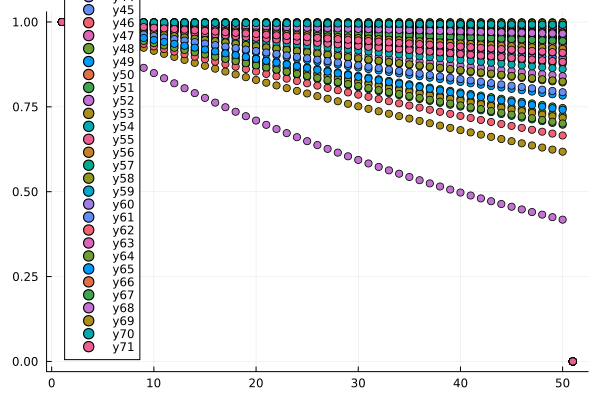

In [12]:
using DataFrames, CSV


In [ ]:
using Plots
scatter()
for row in eachrow(GDP_no_realloc)
    scatter!(row)
end
scatter!()

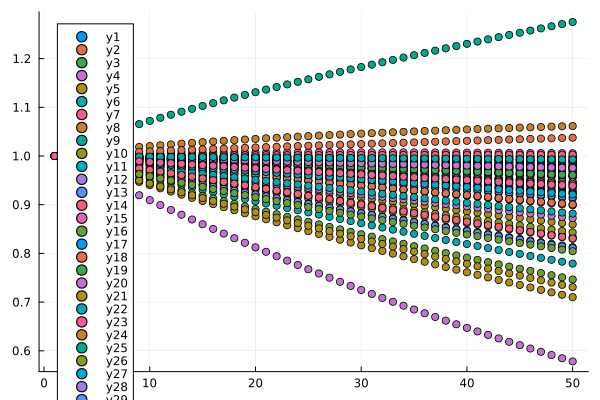

In [13]:
scatter()
for row in eachrow(GDP)
    scatter!(row)
end
scatter!()

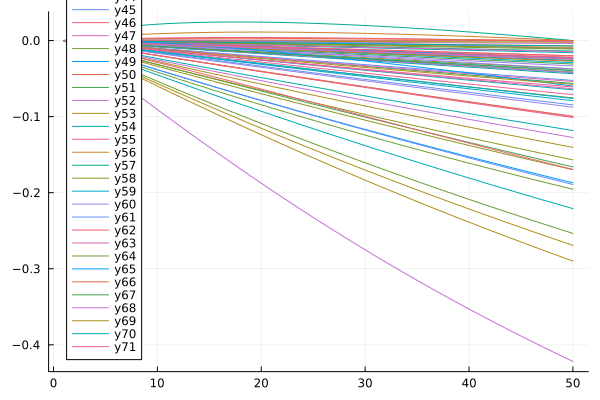

In [14]:
plot()
for row in eachrow(GDP)
    plot!(row -  LinRange(1,maximum(row),50))
end
plot!()

In [15]:
shock_values = LinRange(1.0,1.8,50)
supply_shock = ones(71)

GDP_no_realloc = SharedArray(zeros(71,51))
GDP = SharedArray(zeros(71,50))

@distributed for i in 1:71
    init = Complex.([ones(71)..., data.λ...])
    for (k,shock_value) in enumerate(shock_values)
        demand_shock = ones(71)
        demand_shock[i] = shock_value
        shock = CESModel.Shocks(supply_shock,demand_shock)

        p,q = CESModel.solve_ces_model(data,shock,elasticities,init = init,labor_reallocation = labor_realloc)
        GDP_no_realloc[i,k] = CESModel.real_gdp(p,q,data)
        init = Complex.([p...,q...])
    end
end

@distributed for i in 1:71
    init = Complex.([ones(71)..., data.λ...])
    for (k,shock_value) in enumerate(shock_values)
        demand_shock = ones(71)
        demand_shock[i] = shock_value
        shock = CESModel.Shocks(supply_shock,demand_shock)

        p,q = CESModel.solve_ces_model(data,shock,elasticities,init = init)
        GDP[i,k] = CESModel.real_gdp(p,q,data)
        init = Complex.([p...,q...])
    end
end


Task (done) @0x0000000140f7c7f0

In [16]:
function savetabular(filname,gdp)
    sectors = data.io.Sektoren[1:71]
    df = DataFrame(gdp[1:end,:]',sectors)
    df[:,:DemandShockAmount] = collect(shock_values)
    CSV.write(joinpath(pwd(),"data",filname),df)
end